In [1]:
import os
os.chdir("../")
%env CUDA_VISIBLE_DEVICES=1
#%matplotlib inline

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.measure import compare_psnr
import tensorflow as tf
from data.dataset import Dataset
import data.data_selector as ds
import utils.data_processing as dp
import utils.plot_functions as pf
import analysis.analysis_picker as ap

/home/ryanchan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ryanchan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ryanchan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ryanchan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [3]:
# [name[17:-4] for name in os.listdir(os.path.expanduser("~/Work/Projects/lca_subspace_vh/logfiles"))]

## Prelimiaries

In [531]:
def load_analyzer(version, model_name="lca_subspace_vh", model_type="lca_subspace", save_info="analysis_train"):
    class params:
         def __init__(self, model_name, model_type, version, save_info):
            self.model_type = model_type
            self.model_name = model_name
            self.version = version
            self.save_info = save_info
            self.overwrite_analysis_log = False
        
    analysis_params = params(model_name, model_type, version)
    analysis_params.project_dir = os.path.expanduser("~")+"/Work/Projects/"
    analysis_params.model_dir = (analysis_params.project_dir+analysis_params.model_name) 
    
    analyzer = ap.get_analyzer(analysis_params.model_type)
    analyzer.setup(analysis_params)
    analyzer.setup_model(analyzer.model_params)
    analyzer.load_analysis(save_info=analysis_params.save_info)
    analyzer.model_name = analysis_params.model_name
    return analyzer, analysis_params

In [ ]:
dataset = ds.get_data(analyzer.model_params)

# dataset = analyzer.model.preprocess_dataset(dataset, analyzer.model_params)
# dataset = analyzer.model.reshape_dataset(dataset, analyzer.model_params)
# target_image = dataset["train"].images[0,...]

## Reconstruction of Full Image

In [ ]:
def get_full_images(analyzer, num_images):
    class img_params():
        def __init__(self, num_images):
            self.data_type = analyzer.model_params.data_type
            self.num_images = num_images
            self.extract_patches = False
            self.image_edge_size = 128
            self.data_dir = os.path.expanduser("~")+"/Work/Datasets/"
            self.rand_seed = 10
            self.rand_state = np.random.RandomState(self.rand_seed)
    #         self.rand_seed = analyzer.model_params.rand_seed
    #         self.rand_state = np.random.RandomState(analysis_params.rand_seed)
    dataset = ds.get_data(img_params(num_images))
    full_image = dp.reshape_data(dataset["train"].images[:num_images], flatten=False)[0]
    return full_image

def get_normed_images(full_image, full_recon):
    normed_image = (
      (full_image - np.min(full_image))
      / (np.max(full_image) - np.min(full_image))).astype(np.float32)

    normed_recon = (
      (full_recon - np.min(full_recon))
      / (np.max(full_recon) - np.min(full_recon))).astype(np.float32)
    return normed_image, normed_recon

In [ ]:
log_names = [name[17:-4] for name in os.listdir(os.path.expanduser("~/Work/Projects/lca_subspace_vh/logfiles"))]
log_names.sort()
log_names = log_names[1:]
log_names.pop(2)
num_images = 1
filtered_log_names = log_names
print(filtered_log_names)

class params:
    def __init__(self, version):
        self.model_type = "lca_subspace"
        self.model_name = "lca_subspace_vh"
#         self.version = "4_3.0_0.3"
        self.version = version
        self.save_info = "analysis_train"
        self.overwrite_analysis_log = False
        
    full_images = get_full_images(analyzer, num_images)
for v in ["5x_4_1.0_0.2", "5x_4_1.5_0.2", "5x_4_2.0_0.2"]:
    print(v)
    if analyzer.model_params.whiten_data:
      # FT method is the only one that works on full images
      wht_img, img_mean, ft_filter = dp.whiten_data(full_image,
        method="FT", lpf_cutoff=analyzer.model_params.lpf_cutoff)
    else:
      wht_img = full_image
    img_patches = dp.extract_patches(wht_img,
      out_shape=(1, analyzer.model_params.patch_edge_size, analyzer.model_params.patch_edge_size, 1),
      overlapping=False, randomize=False, var_thresh=0.0)
    img_patches, orig_shape = dp.reshape_data(img_patches, flatten=True)[:2]
    model_eval = analyzer.evaluate_model(img_patches,
      ["inference/activity:0", "output/reconstruction:0"])
    recon_patches = model_eval["output/reconstruction:0"]
    a_vals = model_eval["inference/activity:0"]
    recon_patches = dp.reshape_data(recon_patches, flatten=False, out_shape=orig_shape)[0]
    full_recon = dp.patches_to_image(recon_patches, full_image.shape).astype(np.float32)
    if analyzer.model_params.whiten_data:
        full_recon = dp.unwhiten_data(full_recon, img_mean, ft_filter, method="FT")
    normed_image, normed_recon = get_normed_images(full_image, full_recon)
    
    if True:
        fig, ax = plt.subplots(1, 2, figsize=(12,12))
        ax[0] = pf.clear_axis(ax[0])
        ax[0].imshow(np.squeeze(normed_image), cmap="Greys_r")
        ax[0].set_title("Input Image", fontsize=16)
        ax[1] = pf.clear_axis(ax[1])
        ax[1].imshow(np.squeeze(normed_recon), cmap="Greys_r")
        psnr = "{:.2f}".format(compare_psnr(normed_image, normed_recon, data_range=1))
        plt.show()
#         fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params.model_name+"_image_recon.png", transparent=True,
#           bbox_inches="tight")
#     except:
#         print(v, "error")
#         continue

In [ ]:
if analyzer.model_params.whiten_data:
  # FT method is the only one that works on full images
  wht_img, img_mean, ft_filter = dp.whiten_data(full_image,
    method="FT", lpf_cutoff=analyzer.model_params.lpf_cutoff)
else:
  wht_img = full_image
img_patches = dp.extract_patches(wht_img,
  out_shape=(1, analyzer.model_params.patch_edge_size, analyzer.model_params.patch_edge_size, 1),
  overlapping=False, randomize=False, var_thresh=0.0)
img_patches, orig_shape = dp.reshape_data(img_patches, flatten=True)[:2]
model_eval = analyzer.evaluate_model(img_patches,
  ["inference/activity:0", "output/reconstruction:0"])
recon_patches = model_eval["output/reconstruction:0"]
a_vals = model_eval["inference/activity:0"]
recon_patches = dp.reshape_data(recon_patches, flatten=False, out_shape=orig_shape)[0]
full_recon = dp.patches_to_image(recon_patches, full_image.shape).astype(np.float32)
if analyzer.model_params.whiten_data:
    full_recon = dp.unwhiten_data(full_recon, img_mean, ft_filter, method="FT")

In [ ]:
normed_image = (
  (analyzer.full_image - np.min(analyzer.full_image))
  / (np.max(analyzer.full_image) - np.min(analyzer.full_image))).astype(np.float32)

normed_recon = (
  (analyzer.full_recon - np.min(analyzer.full_recon))
  / (np.max(analyzer.full_recon) - np.min(analyzer.full_recon))).astype(np.float32)

fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0] = pf.clear_axis(ax[0])
ax[0].imshow(np.squeeze(normed_image), cmap="Greys_r")
ax[0].set_title("Input Image", fontsize=16)
ax[1] = pf.clear_axis(ax[1])
ax[1].imshow(np.squeeze(normed_recon), cmap="Greys_r")
percent_active = "{:.2f}".format(analyzer.recon_frac_act*100)
psnr = "{:.2f}".format(compare_psnr(normed_image, normed_recon, data_range=1))
ax[1].set_title("Reconstruction\n"+percent_active+" percent active"+"\n"+"PSNR = "+psnr, fontsize=16)
plt.show()
fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params.model_name+"_image_recon.png", transparent=True,
  bbox_inches="tight")

## Location Frequency Terms

In [ ]:
analyzer, analysis_params = load_analyzer("5x_0.55", "lca_1280_vh", "lca", "analysis_train")
# analyzer, analysis_params = load_analyzer("5x_4_1.0_0.2", "lca_subspace_vh")
# analyzer, analysis_params = load_analyzer("3", "ica_subspace_vh", "ica_subspace")

In [ ]:
fontsize=16
bf_stats = analyzer.bf_stats
figsize=(15, 5)
plt.rc('text', usetex=True)
fig = plt.figure(figsize=figsize)
gs = fig.add_gridspec(1, 3, wspace=0.3)
ax = fig.add_subplot(gs[0])
x_pos = [x for (y,x) in bf_stats["gauss_centers"]]
y_pos = [y for (y,x) in bf_stats["gauss_centers"]]
ax.scatter(x_pos, y_pos, color='k', s=10)
ax.set_xlim([0, bf_stats["patch_edge_size"]-1])
ax.set_ylim([bf_stats["patch_edge_size"]-1, 0])
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.set_aspect("equal")
ax.set_ylabel("Pixels", fontsize=fontsize)
ax.set_xlabel("Pixels", fontsize=fontsize)
ax.set_title("Centers", fontsize=fontsize, pad=32)

ax = fig.add_subplot(gs[1])
# x_sf = [np.abs(x) for (y,x) in bf_stats["fourier_centers"]]
# y_sf = [np.abs(y) for (y,x) in bf_stats["fourier_centers"]]
# x_sf = [x for (y,x) in bf_stats["fourier_centers"]]
# y_sf = [y for (y,x) in bf_stats["fourier_centers"]]
# max_sf = np.max(np.abs(x_sf+y_sf))
# ax.scatter(x_sf, y_sf, color='k', s=10)
# ax.set_xlim([-max_sf, max_sf])
# ax.set_ylim([-max_sf, max_sf])
# ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
# ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
# ax.set_aspect("equal")
# ax.set_ylabel("Cycles / Patch", fontsize=fontsize)
# ax.set_xlabel("Cycles / Patch", fontsize=fontsize)
# ax.set_title("Spatial Frequencies", fontsize=fontsize, pad=32)
num_bins = 15
bins = np.linspace(0, np.max(bf_stats["spatial_frequencies"]), num_bins)
bin_width = bins[1] - bins[0] / 2
ax.hist(bf_stats["spatial_frequencies"], bins=bins, align="mid", rwidth=bin_width, color="k")
ax.set_xlabel("Cycles / Patch", fontsize=fontsize)
ax.set_ylabel("Count", fontsize=fontsize)
yrange = max(ax.get_ylim()) - min(ax.get_ylim())
xrange = max(ax.get_xlim()) - min(ax.get_xlim())
aspect = xrange/yrange
ax.set_aspect(aspect)
ax.set_title("Spatial Frequencies", fontsize=fontsize, pad=32)
orientations = [np.pi + orientation
for orientation in [np.arctan2(*fyx[::-1]) for fyx in bf_stats["fourier_centers"]]]

num_bins = 360
bins = np.linspace(0, 2*np.pi, num_bins)
count, bin_edges = np.histogram(orientations, bins)
count = count / np.max(count)
bin_left, bin_right = bin_edges[:-1], bin_edges[1:]
bin_centers = bin_left + (bin_right - bin_left)/2
ax = fig.add_subplot(gs[2], polar=True)
ax.plot(bin_centers, count, linewidth=3, color='k')
ax.set_yticks([])
ax.set_thetamin(0)
ax.set_thetamax(2*np.pi)
ax.set_xticks([0, np.pi/4, 2*np.pi/4, 3*np.pi/4, 4*np.pi/4,
    5*np.pi/4, 6*np.pi/4, 7*np.pi/4, 2*np.pi])
ax.set_xticklabels([r"0", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$",
    r"$\frac{3\pi}{4}$", r"$\pi$", r"$\frac{5\pi}{4}$", r"$\frac{3\pi}{2}$",
    r"$\frac{7\pi}{4}$"], fontsize=fontsize)
ax.set_title("Orientaitons", fontsize=fontsize, pad=23)
plt.show()

In [ ]:
fig = pf.plot_loc_freq_summary(analyzer.bf_stats, figsize=(12, 4), fontsize=16)
fig.savefig(analyzer.analysis_out_dir+"/vis/fig_location_frequency_centers.png")

In [ ]:
keys=["a_fraction_active", "recon_loss", "sparse_loss", "total_loss"]
labels=["activity", "recon loss", "sparse loss", "total loss"]
stats_fig = pf.plot_stats(analyzer.run_stats, keys=keys, labels=labels, start_index=100, figsize=(10,10))
stats_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params.model_name+"_train_stats.png")

In [ ]:
ot_fig = pf.plot_contrast_orientation_tuning(analyzer.ot_grating_responses["neuron_indices"],
  analyzer.ot_grating_responses["contrasts"],
  analyzer.ot_grating_responses["orientations"],
  analyzer.ot_grating_responses["mean_responses"])
ot_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params.model_name+"_orientation_tuning.pdf")

# iso-response

In [ ]:
vector_id = 4
analyzer.bf_id0 = 50#vectors[vector_id, 0] # RICA 83, 85; vae 4, 72; lca 3, 588
analyzer.bf_id1 = 10#vectors[vector_id, 1]
fig, ax = plt.subplots(2)
ax[0] = pf.clear_axis(ax[0])
ax[0].imshow(analyzer.bf_stats["basis_functions"][analyzer.bf_id0], cmap="Greys_r")
ax[0].set_title(str(analyzer.bf_id0))
ax[1] = pf.clear_axis(ax[1])
ax[1].imshow(analyzer.bf_stats["basis_functions"][analyzer.bf_id1], cmap="Greys_r")
ax[1].set_title(str(analyzer.bf_id1))
plt.show()

In [ ]:
analyzer.bf0 = analyzer.bf_stats["basis_functions"][analyzer.bf_id0].reshape(
(analyzer.model_params.num_pixels))
analyzer.bf1 = analyzer.bf_stats["basis_functions"][analyzer.bf_id1].reshape(
(analyzer.model_params.num_pixels))
analyzer.bf0_norm = np.linalg.norm(analyzer.bf0)
analyzer.bf1_norm = np.linalg.norm(analyzer.bf1)
analyzer.bf0 = analyzer.bf0 / analyzer.bf0_norm
analyzer.bf1 = analyzer.bf1 / analyzer.bf1_norm

print("BF indices = [",analyzer.bf_id0,", ",analyzer.bf_id1,"]")
print("bf0 norm = ", analyzer.bf0_norm)
print("bf1 norm = ", analyzer.bf1_norm)

In [ ]:
num_imgs = int(228**2)
x_pts = np.linspace(-2.0, 2.0, int(np.sqrt(num_imgs)))
y_pts = np.linspace(-2.0, 2.0, int(np.sqrt(num_imgs)))
X_mesh, Y_mesh = np.meshgrid(x_pts, y_pts)
proj_datapoints = np.stack([X_mesh.reshape(num_imgs), Y_mesh.reshape(num_imgs)], axis=1)

analyzer.proj_datapoints = proj_datapoints
analyzer.proj_matrix, v = analyzer.bf_projections(analyzer.bf0, analyzer.bf1)
analyzer.proj_neuron0 = np.dot(analyzer.proj_matrix, analyzer.bf0).T
analyzer.proj_neuron1 = np.dot(analyzer.proj_matrix, analyzer.bf1).T
analyzer.proj_v = np.dot(analyzer.proj_matrix, v).T

analyzer.datapoints = np.stack([np.dot(analyzer.proj_matrix.T, analyzer.proj_datapoints[data_id,:])
for data_id in range(num_imgs)]) #inject
analyzer.datapoints, orig_shape = dp.reshape_data(analyzer.datapoints, flatten=False)[:2]
analyzer.datapoints = {"test": Dataset(analyzer.datapoints, lbls=None, ignore_lbls=None, rand_state=analyzer.rand_state)}
params={"whiten_data":analyzer.model_params.whiten_data}
if params["whiten_data"]:
    params["whiten_method"] = analyzer.model_params.whiten_method
analyzer.datapoints = analyzer.model.preprocess_dataset(analyzer.datapoints, params=params)
analyzer.datapoints = analyzer.model.reshape_dataset(analyzer.datapoints, analyzer.model_params)
analyzer.datapoints["test"].images /= np.max(np.abs(analyzer.datapoints["test"].images))
analyzer.datapoints["test"].images *= 3*analyzer.analysis_params.input_scale

In [ ]:
activations = analyzer.compute_activations(analyzer.datapoints["test"].images)
#activations = analyzer.evaluate_model(analyzer.datapoints["test"].images, [analyzer.model.module.u_list[1].name])[analyzer.model.module.u_list[1].name]
activity_max = np.amax(np.abs(activations)) # Rescale between -1 and 1
analyzer.norm_activity = activations / (activity_max + 0.00001)

In [ ]:
num_plots_y = 1
num_plots_x = 2
gs1 = gridspec.GridSpec(num_plots_y, num_plots_x, wspace=0.5, width_ratios=[4, 1])
fig = plt.figure(figsize=(6,6))
curve_ax = pf.clear_axis(fig.add_subplot(gs1[0]))
#cmap = plt.get_cmap('tab20b')
cmap = plt.get_cmap('viridis')
vmin = np.floor(np.min(analyzer.norm_activity))#0.0
vmax = np.ceil(np.max(analyzer.norm_activity))#1.0

#name_suffix = "continuous"
#pts = curve_ax.scatter(analyzer.proj_datapoints[:,0], analyzer.proj_datapoints[:,1],
#  vmin=vmin, vmax=vmax, cmap=cmap, alpha=0.5, c=analyzer.norm_activity[:, analyzer.bf_id0], s=5.0)

levels = 5
name_suffix = ""
contsf = curve_ax.contourf(X_mesh, Y_mesh,
analyzer.norm_activity[:,analyzer.bf_id0].reshape(int(np.sqrt(num_imgs)),
int(np.sqrt(num_imgs))), levels=levels, vmin=vmin, vmax=vmax, alpha=1.0, antialiased=True, cmap=cmap)

curve_ax.arrow(0, 0, analyzer.proj_neuron0[0].item(),
analyzer.proj_neuron0[1].item(), width=0.05, head_width=0.15,
head_length=0.15, fc='r', ec='r')
curve_ax.arrow(0, 0, analyzer.proj_neuron1[0].item(),
analyzer.proj_neuron1[1].item(), width=0.05, head_width=0.15,
head_length=0.15, fc='w', ec='w')
#curve_ax.arrow(0, 0, analyzer.proj_v[0].item(), analyzer.proj_v[1].item(), width=0.05, head_width=0.15,
# head_length=0.15, linestyle="-.", fc='k', ec='k')

#curve_ax.set_title("Angle = "+"{:.2f}".format(analyzer.neuron_angles[bf_id0, bf_id1])+" deg", fontsize=16)
curve_ax.set_ylim([-2, 2.0])
curve_ax.set_xlim([-2, 2.0])
curve_ax.set_aspect("equal")
#cbar = pf.add_colorbar_to_im(pts, aspect=20, pad_fraction=0.5, labelsize=16, ticks=[vmin, vmax])
#cbar.ax.set_yticklabels(["{:.0f}".format(vmin), "{:.0f}".format(vmax)])

gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, gs1[1], wspace=2, hspace=-0.55)
bf1_ax = pf.clear_axis(fig.add_subplot(gs2[0]))
bf1_ax.imshow(analyzer.bf_stats["basis_functions"][analyzer.bf_id0], cmap="Greys_r")
bf1_ax.set_title("Primary\nBasis Function", color='r', fontsize=16)
bf2_ax = pf.clear_axis(fig.add_subplot(gs2[1]))
bf2_ax.imshow(analyzer.bf_stats["basis_functions"][analyzer.bf_id1], cmap="Greys_r")
bf2_ax.set_title("Comparison\nBasis Function", color='k', fontsize=16)
fig.savefig(analyzer.analysis_out_dir+"/vis/neuron_response_contours_bf0id"+str(analyzer.bf_id0)+"_bf1id"+str(analyzer.bf_id1)+name_suffix+".png",
transparent=True, bbox_inches="tight", pad_inches=0.01)
plt.show()

In [ ]:
I = np.arange(10)*10
for i in np.arange(0, 100, 4):
    for j in np.arange(4):
        if i == j:
            continue
        try:
            print("working on ", i, i+j)
            vector_id = 4
            analyzer.bf_id0 = i#50#vectors[vector_id, 0] # RICA 83, 85; vae 4, 72; lca 3, 588
            analyzer.bf_id1 = i+j#10#vectors[vector_id, 1]
        #     fig, ax = plt.subplots(2)
        #     ax[0] = pf.clear_axis(ax[0])
        #     ax[0].imshow(analyzer.bf_stats["basis_functions"][analyzer.bf_id0], cmap="Greys_r")
        #     ax[0].set_title(str(analyzer.bf_id0))
        #     ax[1] = pf.clear_axis(ax[1])
        #     ax[1].imshow(analyzer.bf_stats["basis_functions"][analyzer.bf_id1], cmap="Greys_r")
        #     ax[1].set_title(str(analyzer.bf_id1))
        #     plt.show()

            analyzer.bf0 = analyzer.bf_stats["basis_functions"][analyzer.bf_id0].reshape(
            (analyzer.model_params.num_pixels))
            analyzer.bf1 = analyzer.bf_stats["basis_functions"][analyzer.bf_id1].reshape(
            (analyzer.model_params.num_pixels))
            analyzer.bf0_norm = np.linalg.norm(analyzer.bf0)
            analyzer.bf1_norm = np.linalg.norm(analyzer.bf1)
            analyzer.bf0 = analyzer.bf0 / analyzer.bf0_norm
            analyzer.bf1 = analyzer.bf1 / analyzer.bf1_norm

            print("BF indices = [",analyzer.bf_id0,", ",analyzer.bf_id1,"]")
            print("bf0 norm = ", analyzer.bf0_norm)
            print("bf1 norm = ", analyzer.bf1_norm)

            num_imgs = int(228**2)
            x_pts = np.linspace(-2.0, 2.0, int(np.sqrt(num_imgs)))
            y_pts = np.linspace(-2.0, 2.0, int(np.sqrt(num_imgs)))
            X_mesh, Y_mesh = np.meshgrid(x_pts, y_pts)
            proj_datapoints = np.stack([X_mesh.reshape(num_imgs), Y_mesh.reshape(num_imgs)], axis=1)

            analyzer.proj_datapoints = proj_datapoints
            analyzer.proj_matrix, v = analyzer.bf_projections(analyzer.bf0, analyzer.bf1)
            analyzer.proj_neuron0 = np.dot(analyzer.proj_matrix, analyzer.bf0).T
            analyzer.proj_neuron1 = np.dot(analyzer.proj_matrix, analyzer.bf1).T
            analyzer.proj_v = np.dot(analyzer.proj_matrix, v).T

            analyzer.datapoints = np.stack([np.dot(analyzer.proj_matrix.T, analyzer.proj_datapoints[data_id,:])
            for data_id in range(num_imgs)]) #inject
            analyzer.datapoints, orig_shape = dp.reshape_data(analyzer.datapoints, flatten=False)[:2]
            analyzer.datapoints = {"test": Dataset(analyzer.datapoints, lbls=None, ignore_lbls=None, rand_state=analyzer.rand_state)}
            params={"whiten_data":analyzer.model_params.whiten_data}
            if params["whiten_data"]:
                params["whiten_method"] = analyzer.model_params.whiten_method
            analyzer.datapoints = analyzer.model.preprocess_dataset(analyzer.datapoints, params=params)
            analyzer.datapoints = analyzer.model.reshape_dataset(analyzer.datapoints, analyzer.model_params)
            analyzer.datapoints["test"].images /= np.max(np.abs(analyzer.datapoints["test"].images))
            analyzer.datapoints["test"].images *= 3*analyzer.analysis_params.input_scale

            activations = analyzer.compute_activations(analyzer.datapoints["test"].images)
            #activations = analyzer.evaluate_model(analyzer.datapoints["test"].images, [analyzer.model.module.u_list[1].name])[analyzer.model.module.u_list[1].name]
            activity_max = np.amax(np.abs(activations)) # Rescale between -1 and 1
            analyzer.norm_activity = activations / (activity_max + 0.00001)

            num_plots_y = 1
            num_plots_x = 2
            gs1 = gridspec.GridSpec(num_plots_y, num_plots_x, wspace=0.5, width_ratios=[4, 1])
            fig = plt.figure(figsize=(6,6))
            curve_ax = pf.clear_axis(fig.add_subplot(gs1[0]))
            #cmap = plt.get_cmap('tab20b')
            cmap = plt.get_cmap('viridis')
            vmin = np.floor(np.min(analyzer.norm_activity))#0.0
            vmax = np.ceil(np.max(analyzer.norm_activity))#1.0

            #name_suffix = "continuous"
            #pts = curve_ax.scatter(analyzer.proj_datapoints[:,0], analyzer.proj_datapoints[:,1],
            #  vmin=vmin, vmax=vmax, cmap=cmap, alpha=0.5, c=analyzer.norm_activity[:, analyzer.bf_id0], s=5.0)

            levels = 5
            name_suffix = ""
            contsf = curve_ax.contourf(X_mesh, Y_mesh,
            analyzer.norm_activity[:,analyzer.bf_id0].reshape(int(np.sqrt(num_imgs)),
            int(np.sqrt(num_imgs))), levels=levels, vmin=vmin, vmax=vmax, alpha=1.0, antialiased=True, cmap=cmap)

            curve_ax.arrow(0, 0, analyzer.proj_neuron0[0].item(),
            analyzer.proj_neuron0[1].item(), width=0.05, head_width=0.15,
            head_length=0.15, fc='r', ec='r')
            curve_ax.arrow(0, 0, analyzer.proj_neuron1[0].item(),
            analyzer.proj_neuron1[1].item(), width=0.05, head_width=0.15,
            head_length=0.15, fc='w', ec='w')
            #curve_ax.arrow(0, 0, analyzer.proj_v[0].item(), analyzer.proj_v[1].item(), width=0.05, head_width=0.15,
            # head_length=0.15, linestyle="-.", fc='k', ec='k')

            #curve_ax.set_title("Angle = "+"{:.2f}".format(analyzer.neuron_angles[bf_id0, bf_id1])+" deg", fontsize=16)
            curve_ax.set_ylim([-2, 2.0])
            curve_ax.set_xlim([-2, 2.0])
            curve_ax.set_aspect("equal")
            #cbar = pf.add_colorbar_to_im(pts, aspect=20, pad_fraction=0.5, labelsize=16, ticks=[vmin, vmax])
            #cbar.ax.set_yticklabels(["{:.0f}".format(vmin), "{:.0f}".format(vmax)])

            gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, gs1[1], wspace=2, hspace=-0.55)
            bf1_ax = pf.clear_axis(fig.add_subplot(gs2[0]))
            bf1_ax.imshow(analyzer.bf_stats["basis_functions"][analyzer.bf_id0], cmap="Greys_r")
            bf1_ax.set_title("Primary\nBasis Function", color='r', fontsize=16)
            bf2_ax = pf.clear_axis(fig.add_subplot(gs2[1]))
            bf2_ax.imshow(analyzer.bf_stats["basis_functions"][analyzer.bf_id1], cmap="Greys_r")
            bf2_ax.set_title("Comparison\nBasis Function", color='k', fontsize=16)
            fig.savefig(analyzer.analysis_out_dir+"/vis/neuron_response_contours_bf0id"+str(analyzer.bf_id0)+"_bf1id"+str(analyzer.bf_id1)+name_suffix+".png",
            transparent=True, bbox_inches="tight", pad_inches=0.01)
            plt.show()
            
        except:
            print(i, j, "failed to show iso-contour")

## VIDEO ANALSIS

In [195]:
# get file paths 
vid_paths = [os.path.join("/home/ryanchan/Work/BIRD_vids",name) for name in os.listdir("/home/ryanchan/Work/BIRD_vids")]
vid_paths

['/home/ryanchan/Work/BIRD_vids/GP005_gray_dn64x.mp4',
 '/home/ryanchan/Work/BIRD_vids/GP006_gray_dn64x.mp4',
 '/home/ryanchan/Work/BIRD_vids/GP003_gray_dn64x.mp4',
 '/home/ryanchan/Work/BIRD_vids/GP008_gray_dn64x.mp4',
 '/home/ryanchan/Work/BIRD_vids/GP007_gray_dn64x.mp4',
 '/home/ryanchan/Work/BIRD_vids/GP001_gray_dn64x.mp4',
 '/home/ryanchan/Work/BIRD_vids/GP002_gray_dn64x.mp4']

In [447]:
# read video from file 
# Path to video file 
vidObj = cv2.VideoCapture(vid_paths[0]) 
success = True
num_imgs = 1024
frames = []
count = 0
while success and count < num_imgs:
    success, image = vidObj.read() 
    if success:
        frames.append(image)
    count += 1
frames = (np.stack(frames) / 255.)[:, :100, :100, :1]

In [448]:
def get_recon_images(analyzer, full_images):
    wht_img, img_mean, ft_filter = dp.whiten_data(full_images,
        method="FT", lpf_cutoff=analyzer.model_params.lpf_cutoff)
    img_patches = wht_img[:, :16, :16, :]
    return img_patches

In [534]:
# load ananlyzer
analyzer, analysis_params = load_analyzer("5x_0.55", "lca_1280_vh", "lca", "analysis_train")

In [535]:
img_patches = get_recon_images(analyzer, frames)
reshaped_img_patches = img_patches.reshape(-1, 256)
with tf.Session(graph=analyzer.model.graph) as sess:
    sess.run(analyzer.model.init_op)
    feed_dict = analyzer.model.get_feed_dict(reshaped_img_patches, is_test=True)
#     group_act = sess.run(analyzer.model.get_group_activity(), feed_dict)
    group_act = sess.run(analyzer.model.a, feed_dict)
#     group_act = group_act[:, :, 0]

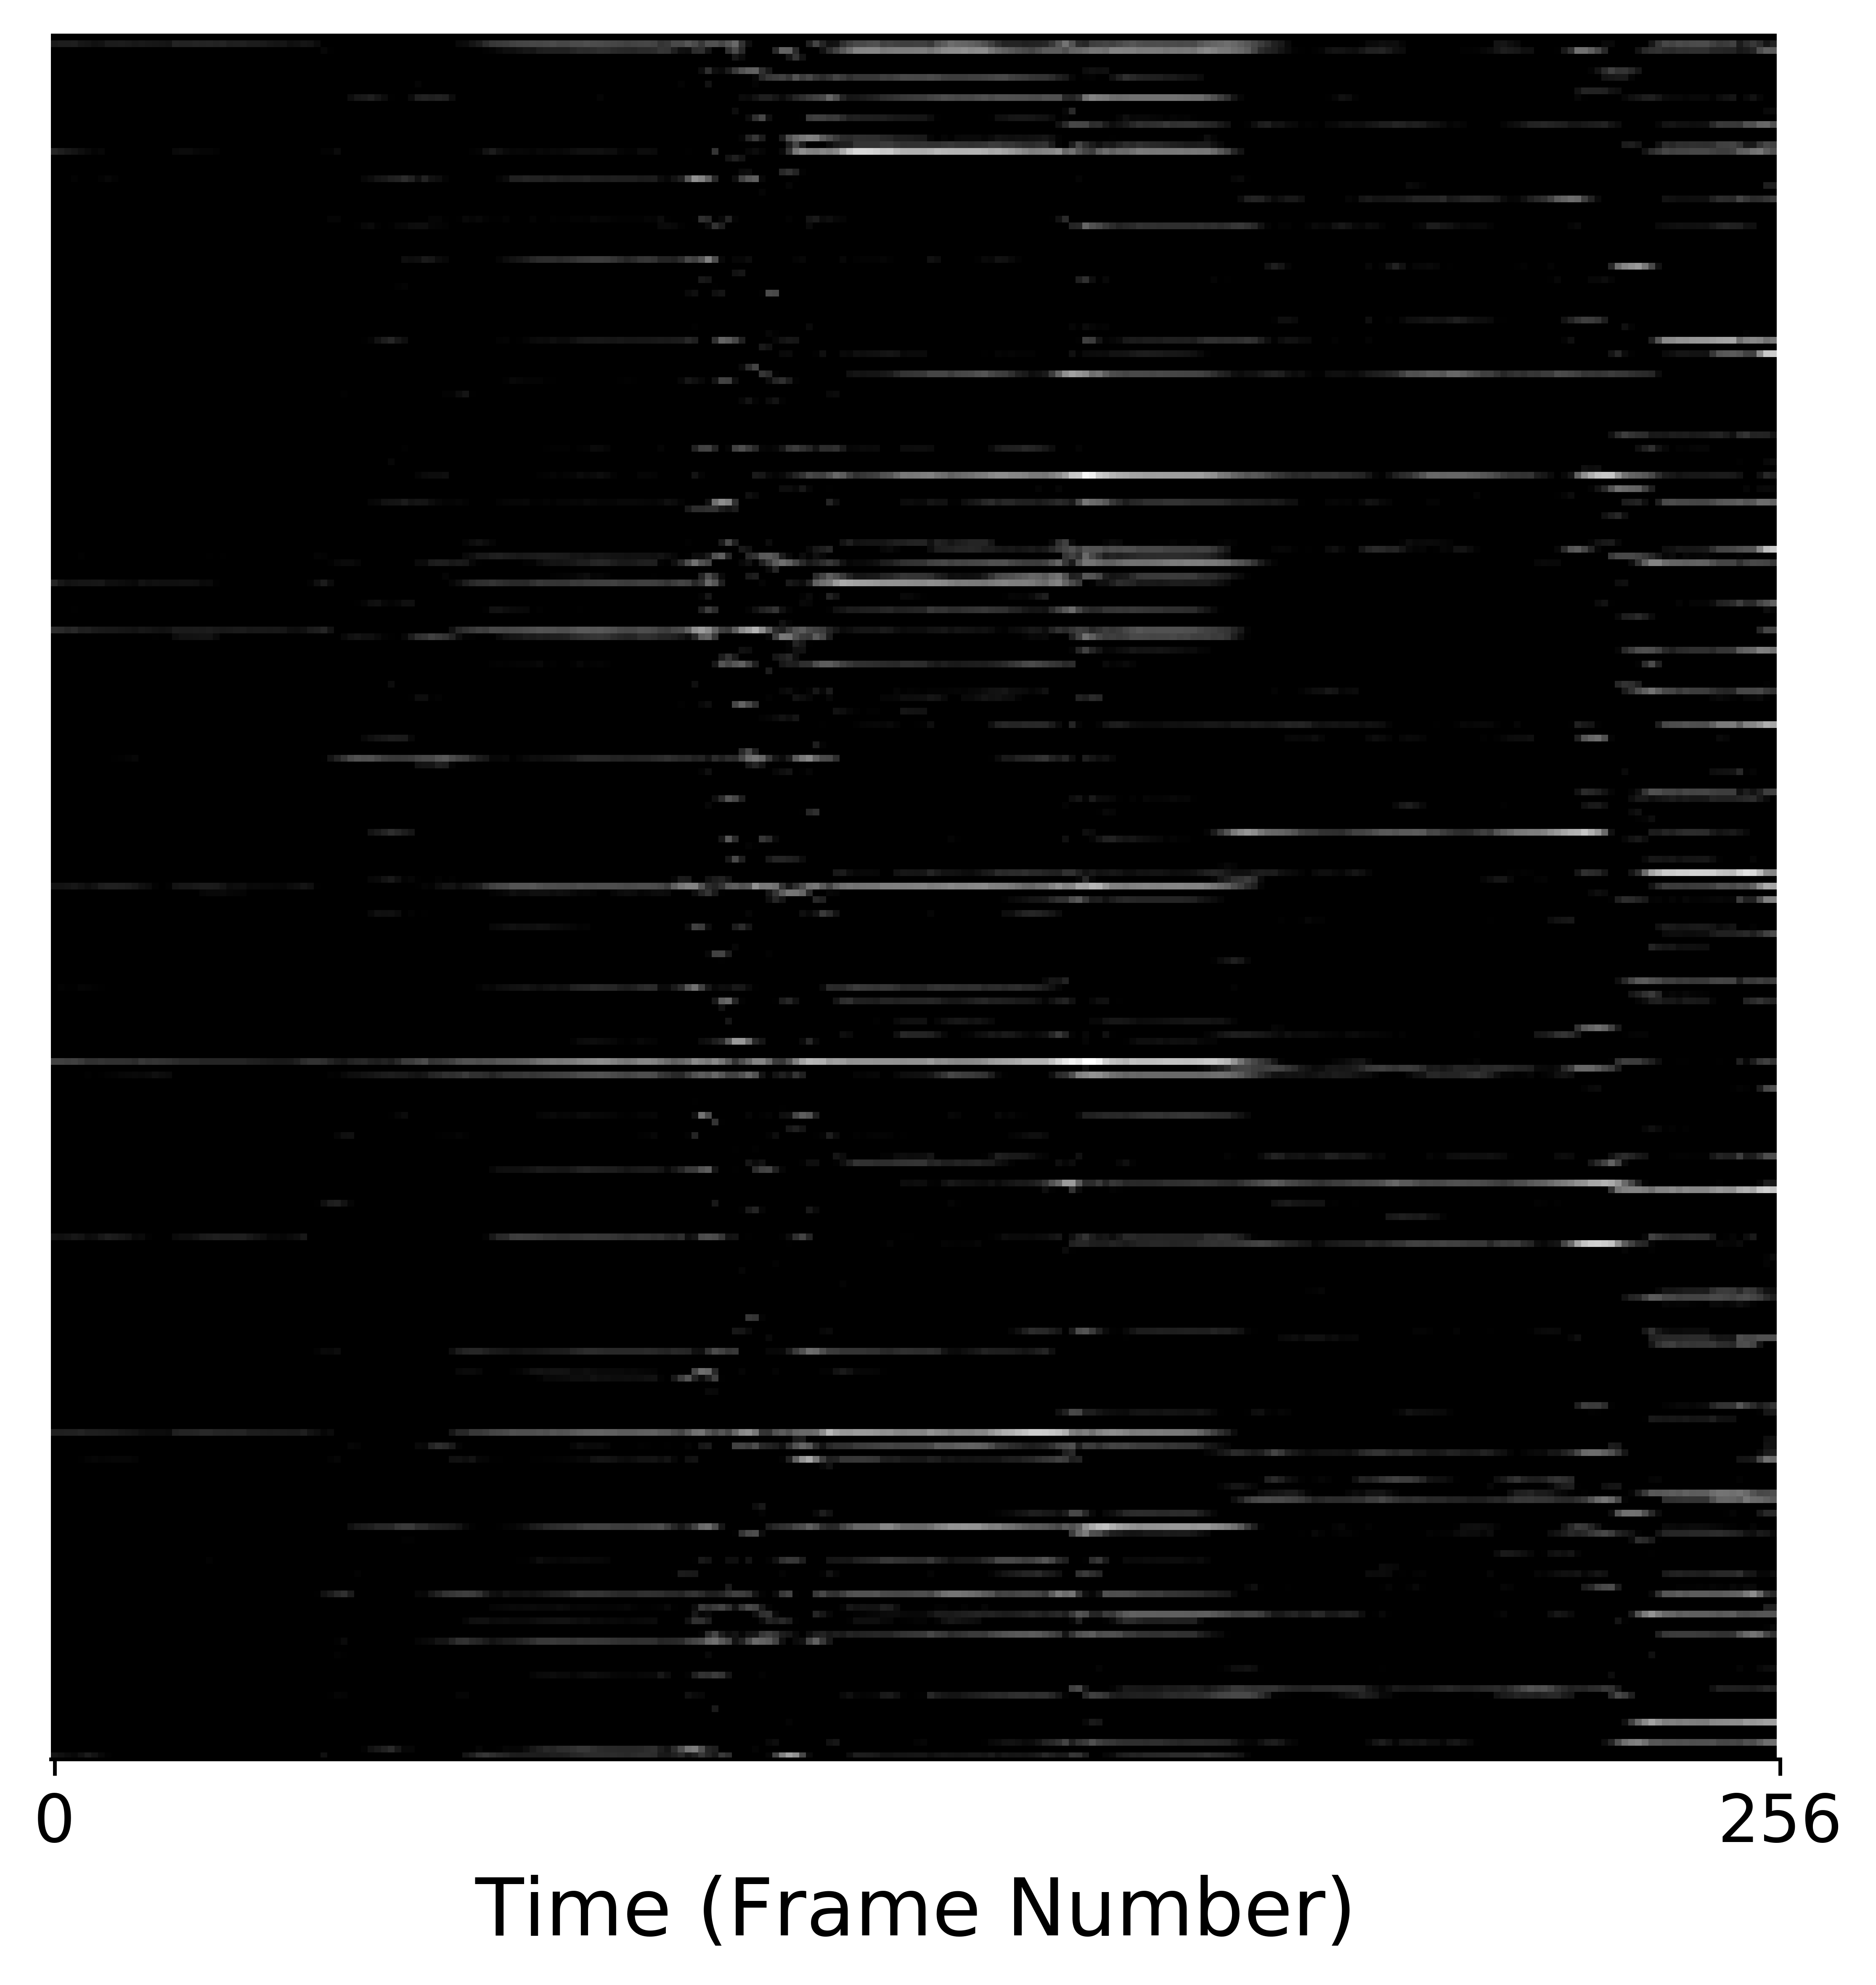

In [537]:
outlined = (np.abs(group_act.T))[:256, :256]
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6), dpi=800)
im = ax.imshow(outlined, cmap="gray")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_xticks([0, len(outlined)])
ax.set_yticks([])
ax.set_xlabel("Time (Frame Number)", fontsize=17)
ax.tick_params(labelsize=14)
fig.tight_layout()

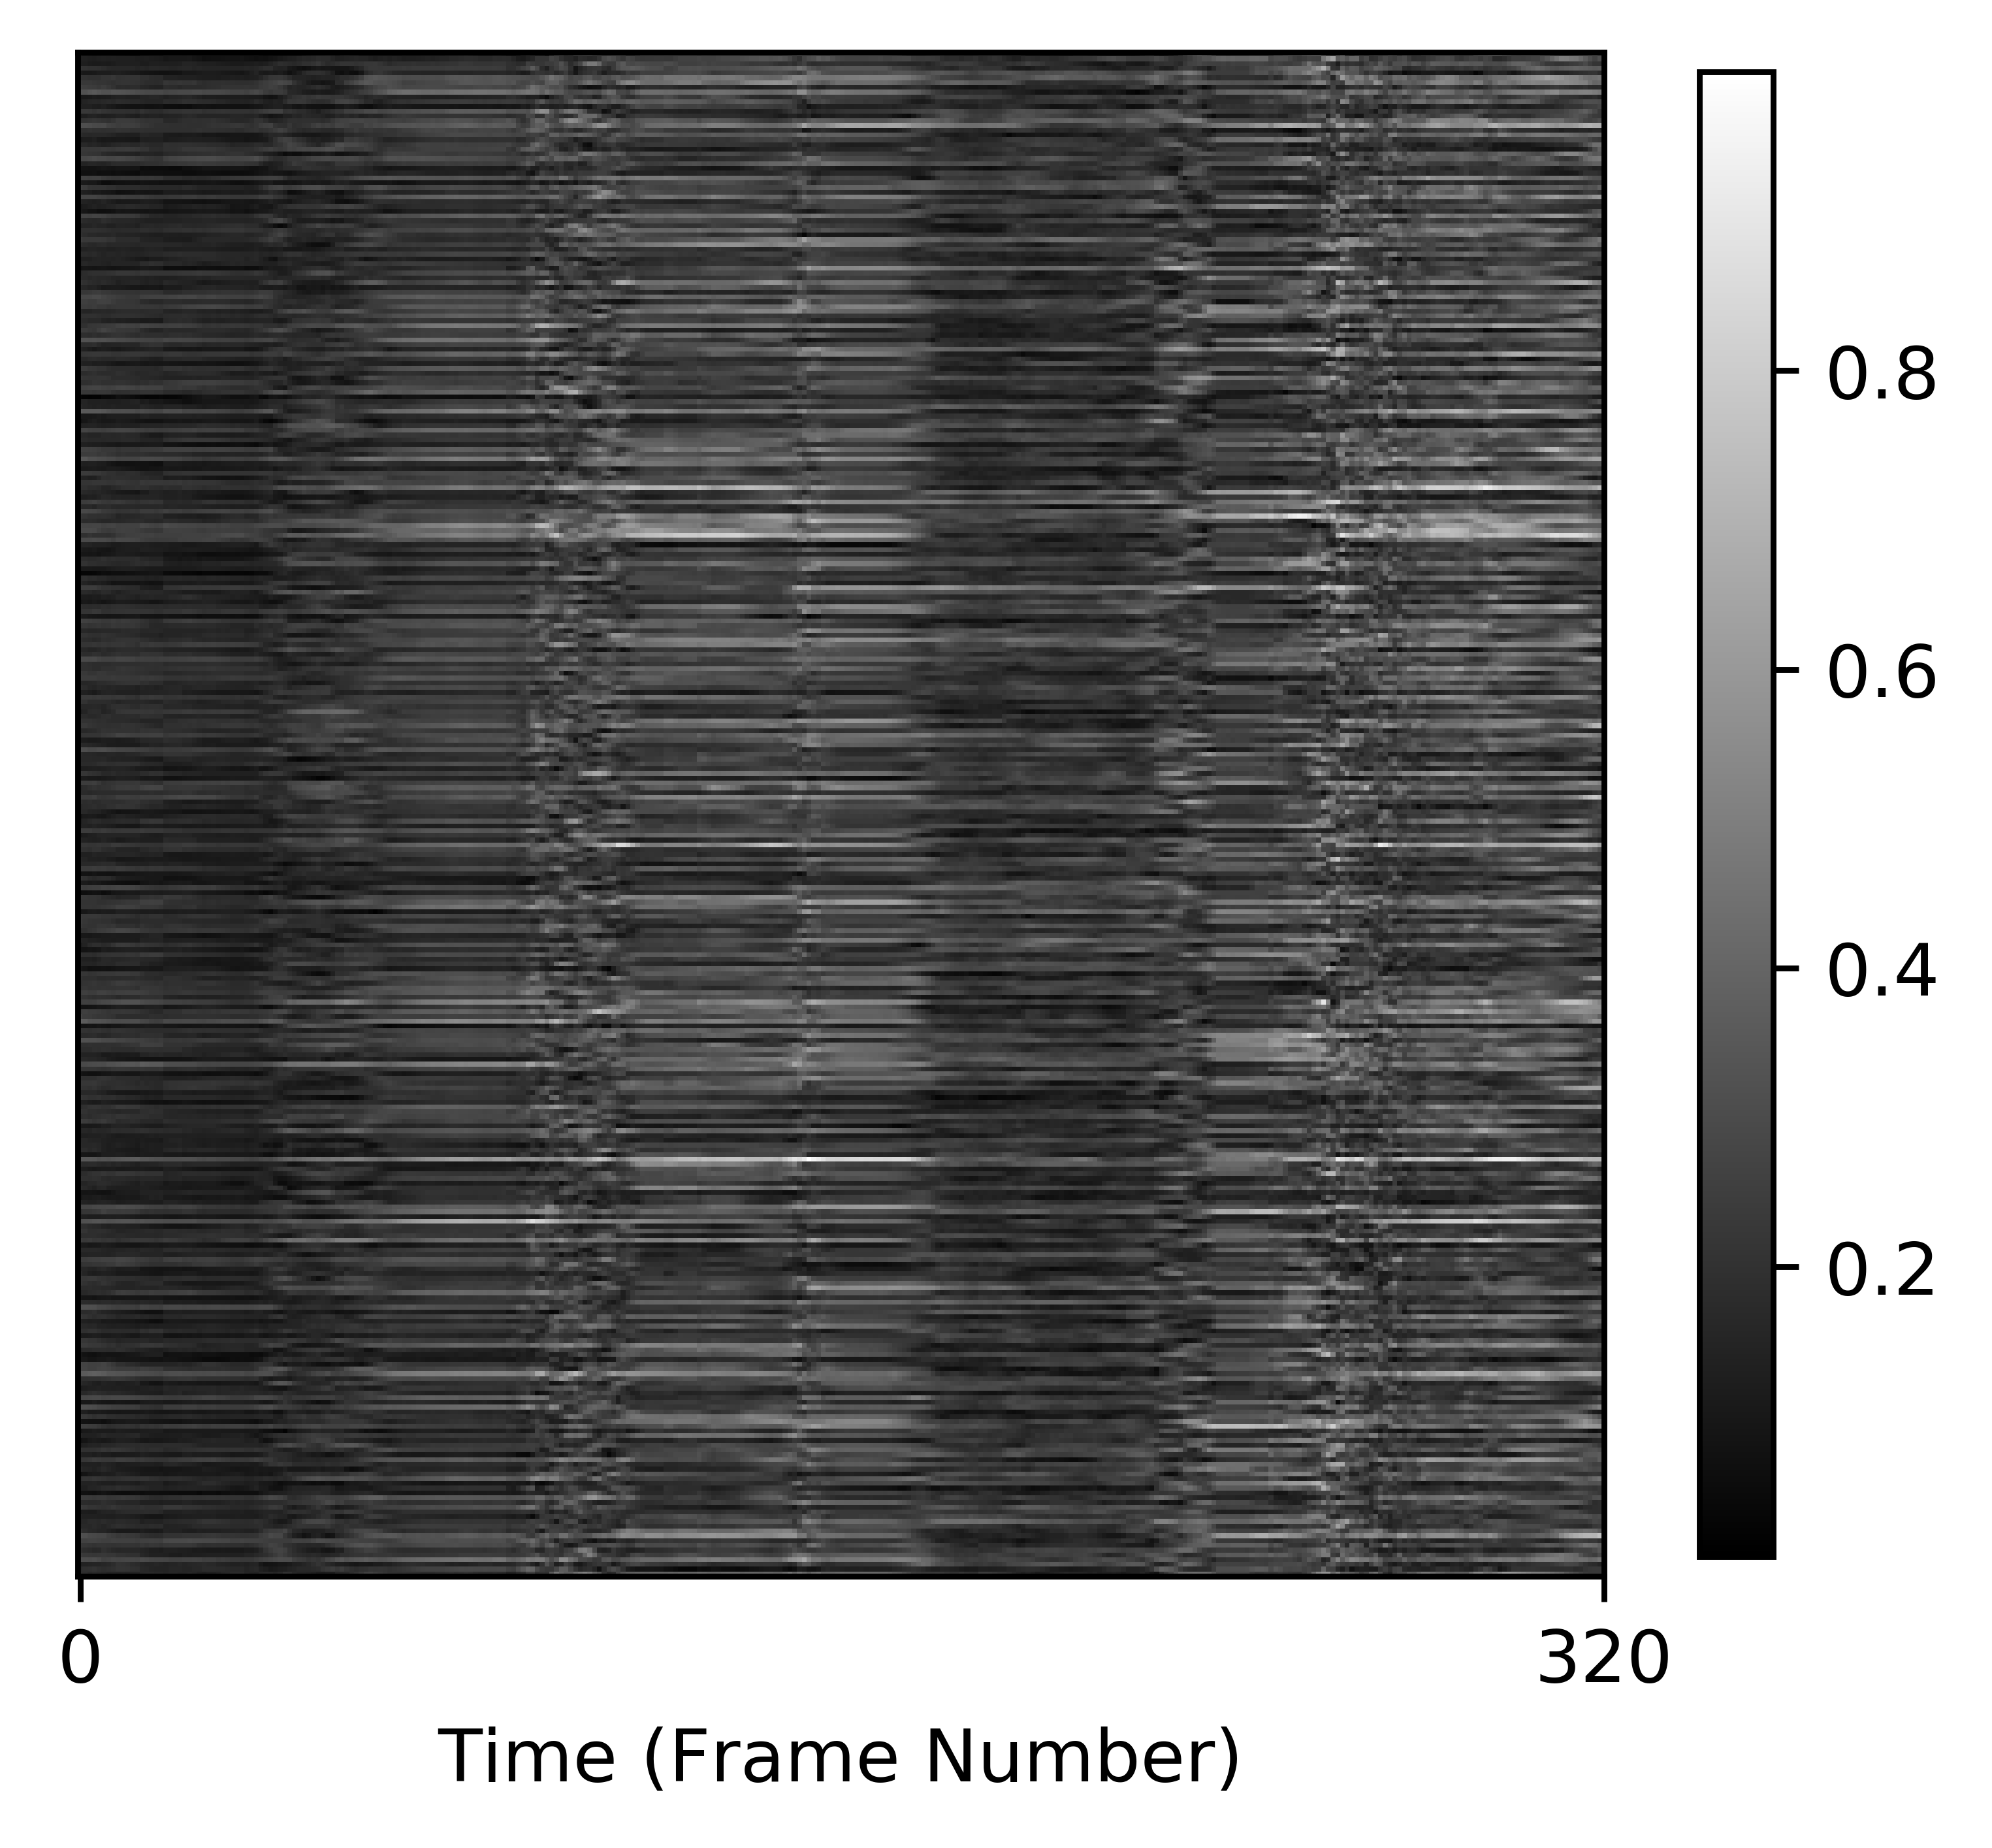

In [325]:
plt.figure(figsize=(4, 4), dpi=800)
im = plt.imshow(group_act.T/np.max(group_act), cmap="gray")
plt.xticks([0, len(group_act)])
plt.yticks([])
plt.xlabel("Time (Frame Number)")
plt.colorbar(im, shrink=0.8)
plt.tight_layout()